In [1]:
from datasets import load_dataset, concatenate_datasets

cmu = load_dataset('CLAPv2/CMU_Arctic')
cmu = concatenate_datasets([*cmu.values()])
display(cmu)
print(f"\n{'-' * 50}\n")
display(cmu[0])

Resolving data files:   0%|          | 0/119 [00:00<?, ?it/s]

Dataset({
    features: ['index', 'datasetname', 'audio', 'audio_len', 'text', 'raw_text'],
    num_rows: 13192
})


--------------------------------------------------



{'index': './train/10005',
 'datasetname': 'FSD50K',
 'audio': <datasets.features._torchcodec.AudioDecoder at 0x7fc7dcc93620>,
 'audio_len': 3.17006254196167,
 'text': 'A man reads out "He was fond of quoting a fragment from a certain poem." in the Scottish accent',
 'raw_text': ['Title: CMU_Arctic',
  'Description: The databases consist of around 1150 utterances carefully selected from out-of-copyright texts from Project Gutenberg. The databses include US English male (bdl) and female (slt) speakers (both experinced voice talent) as well as other accented speakers.',
  'License: BSD',
  'Text: He was fond of quoting a fragment from a certain poem.',
  'Accent: Scottish',
  'Gender: male',
  'Filename: cmu_sc_male/arctic_a0520.wav']}

In [2]:
import re

def get_metadata(record):
    info     = '\n'.join(record['raw_text'])
    patterns = { 
        'speaker'    : r'Filename:\s*([^/]+)',
        'accent'     : r'Accent:\s*([^\n]+)', 
        'sex'        : r'Gender:\s*([^\n]+)',
        'spoken_text': r'Text:\s*([^\n]+)',
    }
    extract_pattern = lambda pattern: re.search(pattern, info).group(1).strip()
    metadata = { 
        key: extract_pattern(patterns[key]) for key in patterns
    }
    return metadata

def get_audio(record):
    audio = record['audio'].get_all_samples()
    samples = audio.data.mean(0)
    samplerate = audio.sample_rate
    return samples, samplerate

def get_audio_attrs(record):
    metadata            = get_metadata(record)
    dataset, samplerate = get_audio(record)
    return metadata, dataset, samplerate

In [3]:
metadata, dataset, samplerates = zip(*map(get_audio_attrs, cmu))

In [4]:
from typing import final

unique_samplerates = list(set(samplerates))
assert len(unique_samplerates) == 1, "When executing this check all the audios should've been already subsampled/supersampled to the same sampling rate."

SAMPLERATE: final = unique_samplerates[0]

In [14]:
import torch
import torchaudio

WIN_MS, HOP_MS   = 15, 5
WIN_LEN, HOP_LEN = map(lambda time_ms: time_ms * SAMPLERATE // 1000, [WIN_MS, HOP_MS])

Spectrogram = torchaudio.transforms.Spectrogram(
    WIN_LEN, WIN_LEN, HOP_LEN, 
    0, torch.hann_window, None,
)

InvSpectrogram = torchaudio.transforms.InverseSpectrogram(
    WIN_LEN, WIN_LEN, HOP_LEN, 
    0, torch.hann_window,
)

def compute_PdB_t(A_ft):
    assert 1 < A_ft.ndim < 4, '`A_ft` MUST be 2D in case it does not have a batch dimension.'
    f_axis = 0 if A_ft.ndim < 3 else 1
    return 10 * torch.log10(torch.square(A_ft).sum(f_axis) + 1e-6)

def apply_vad(samples, dB_thd=-3):
    global Spectrogram, InvSpectrogram
    X_ft         = Spectrogram(samples)
    A_ft, phi_ft = map(lambda func: func(X_ft), [torch.abs, torch.angle])
    PdB_t        = compute_PdB_t(A_ft)
    f_bins       = A_ft.shape[0]
    vad_ft       = (PdB_t >= dB_thd).unsqueeze(0).expand(f_bins, -1)
    A_ft, phi_ft = map(lambda M_ft: M_ft[vad_ft].reshape(f_bins, -1), [A_ft, phi_ft])
    X_ft         = A_ft * torch.exp(1j * phi_ft)
    samples      = InvSpectrogram(X_ft)
    return samples

In [15]:
dataset = tuple(map(apply_vad, dataset))
MAX_SAMPLES: final = max(map(len, dataset))

In [16]:
from collections import defaultdict
import re

key_components = ['accent', 'spoken_text']

audio_groups = defaultdict(list)
for idx, audio in enumerate(metadata):
    key = tuple(audio[x] for x in key_components)
    audio_groups[key].append(idx)

accents, spoken_texts = map(set, zip(*audio_groups.keys()))

print(f'''
Original Recordings:

Total Number of Recordings:      {len(cmu)}
Number of Accents:               {len(accents)}
Number of Spoken Texts:          {len(spoken_texts)}
Number of Accented Spoken Texts: {len(audio_groups)}
''')


Original Recordings:

Total Number of Recordings:      13192
Number of Accents:               5
Number of Spoken Texts:          1248
Number of Accented Spoken Texts: 5181



In [17]:
pairs = []
for key in audio_groups:
    audio_group = audio_groups[key]
    n = len(audio_group)
    if n < 2:
        continue
    for i in range(n-1):
        a = audio_group[i]
        for j in range(i+1, n):
            b = audio_group[j]
            t1, t2 = map(lambda idx: dataset[idx].numel(), [a, b])
            dt = abs(t1 - t2) / min(t1, t2)
            similar_tempos = dt < 0.01
            having_different_speakers = metadata[a]['speaker'] != metadata[b]['speaker']
            if similar_tempos and having_different_speakers:
                pairs.append([a, b])

print(f'''
Different-Speaker, Similar-Tempo, and Same-Accented-Text Recording Pairs:

Total Number of Pairs [Datapoints]: {len(pairs)}
''')


Different-Speaker, Similar-Tempo, and Same-Accented-Text Recording Pairs:

Total Number of Pairs [Datapoints]: 781



In [18]:
from IPython.display import Audio, display
from random import randint

def display_pair(dataset, i, j):
    audios = map(lambda idx: Audio(dataset[idx], rate=SAMPLERATE), [i, j])
    for audio in audios:
        display(audio)

def choose_random_pair(pairs):
    return pairs[randint(0, len(pairs))]

def display_random_pair():
    global dataset, pairs
    pair = choose_random_pair(pairs)
    print(f'\tPair: {pair}\n')
    display_pair(dataset, *pair)
    return pair

i, j = display_random_pair()

	Pair: [3078, 12734]



In [65]:
dataset[i, 1:] - 0.97 * dataset[i, :-1]

TypeError: tuple indices must be integers or slices, not tuple

In [138]:
import torch.nn.functional as F

N_MFCC = 13
N_MELS = 13
ALPHA  = 0.97
L = 50

pre_emphasis = lambda samples, alpha: samples[1:] - alpha * samples[:-1]

MFCCTransformer = torchaudio.transforms.MFCC(
    sample_rate = SAMPLERATE,
    n_mfcc = N_MFCC,
    melkwargs = {
        'n_fft': WIN_LEN,
        'hop_length': HOP_LEN,
        'n_mels': N_MELS,
        'center': True,
        'power': 2.0,
    },
)

MFCC_bt = [
    MFCCTransformer(
        pre_emphasis(
            dataset[idx], 0.97
        )
    ) for idx in [i, j]
]

t_lengths = torch.tensor([
    MFCC_bt[idx].shape[-1] for idx in range(2)
])

t_pads = t_lengths.max() - t_lengths

MFCC_bt = torch.stack([
    F.pad(MFCC_bt[idx], (0, t_pads[idx]), value=MFCC_bt[idx].min()) for idx in range(2)
])

# mel_indices = torch.arange(N_MFCC).float()
# lifter_win  = 1 + (L / 2.0) * torch.sin(torch.pi * mel_indices / L)
# lifter_win  = lifter_win.unsqueeze(0).unsqueeze(-1)

# MFCC_bt = lifter_win * MFCC_bt
# MFCC_bt = MFCC_bt[:,:,1:] - 0.97 * MFCC_bt[:,:,:-1]
MFCC_bt.shape

torch.Size([2, 13, 381])

In [192]:
# rasta

from functools import reduce

b = torch.tensor([0.2,0.1,0.0,-0.1,-0.2]).reshape(1,1,-1)
a = torch.tensor([1.0,-0.94]).reshape(1,1,-1)

n_taps = b.numel()
y_fir = reduce(
    sum, 
    [
        b[:,:,idx] * MFCC_bt[:,:,n_taps-idx-1:-idx if idx > 0 else None] \
        for idx in range(n_taps)
    ]
)

y = F.pad(y_fir, (n_taps - 1, 0))
y

tensor([[[   0.0000,    0.0000,    0.0000,  ..., -591.0726, -601.7107,
          -609.1396],
         [   0.0000,    0.0000,    0.0000,  ..., -219.1977, -304.5060,
          -314.3571],
         [   0.0000,    0.0000,    0.0000,  ..., -300.9740, -372.0551,
          -379.4260],
         ...,
         [   0.0000,    0.0000,    0.0000,  ..., -286.5671, -359.6775,
          -360.7850],
         [   0.0000,    0.0000,    0.0000,  ..., -286.1768, -358.0996,
          -358.2313],
         [   0.0000,    0.0000,    0.0000,  ..., -289.0517, -359.9385,
          -360.6971]],

        [[   0.0000,    0.0000,    0.0000,  ..., -588.7195, -598.2858,
          -601.9178],
         [   0.0000,    0.0000,    0.0000,  ..., -216.8236, -301.7669,
          -310.9663],
         [   0.0000,    0.0000,    0.0000,  ..., -298.8709, -370.0840,
          -380.0580],
         ...,
         [   0.0000,    0.0000,    0.0000,  ..., -286.1245, -358.8214,
          -359.8658],
         [   0.0000,    0.0000,    0.000

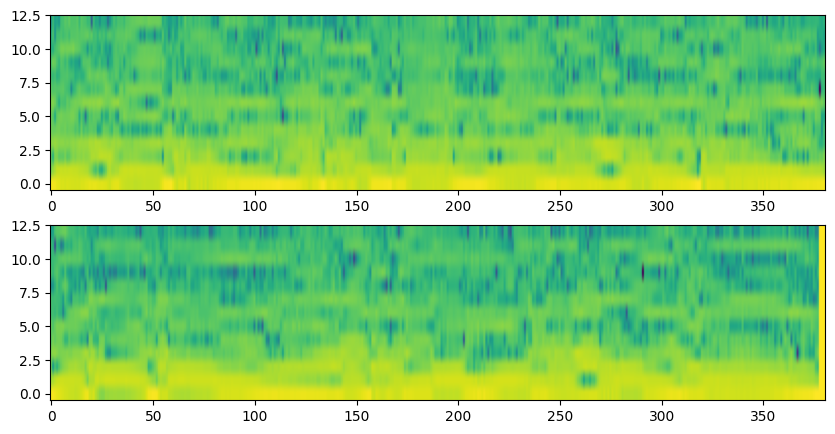

In [148]:
images = torch.log10(torch.square(MFCC_bt)).detach().clone().numpy()
_, axs = plt.subplots(2, 1, figsize=(10,5))
axs[0].imshow(images[0], aspect='auto', origin='lower')
axs[1].imshow(images[1], aspect='auto', origin='lower')

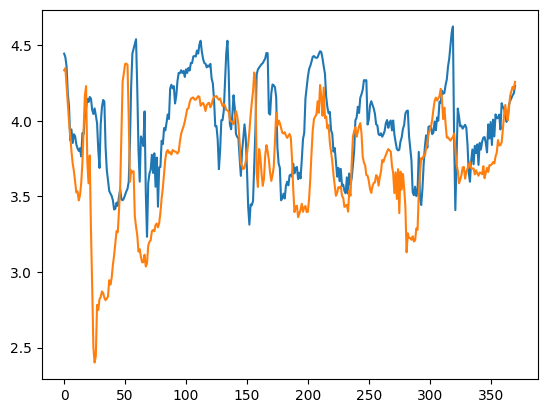

In [149]:
plt.plot(range(images.shape[-1]-10), images[0,0,:-10])
plt.plot(range(images.shape[-1]-10), images[1,0,:-10])

In [10]:
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence

X_t = pad_sequence([ 
    dataset[i],
    dataset[j],
]).T

X_ft = Spectrogram(X_t)

A_ft   = torch.abs(X_ft)
phi_ft = torch.angle(X_ft)

PdB_ft = 10 * torch.log10(A_ft + 1e-6)

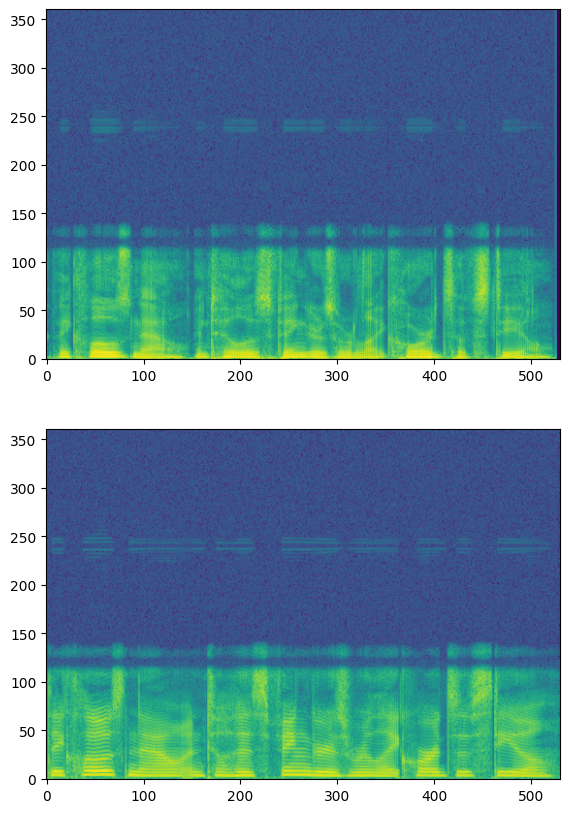

In [11]:
images = PdB_ft.detach().clone().numpy()
_, axs = plt.subplots(2, 1, figsize=(20, 10))
axs[0].imshow(images[0], origin='lower')
axs[1].imshow(images[1], origin='lower')

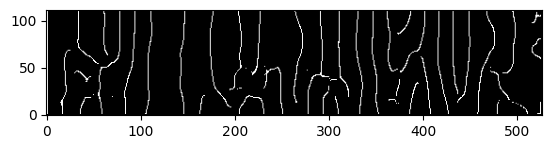

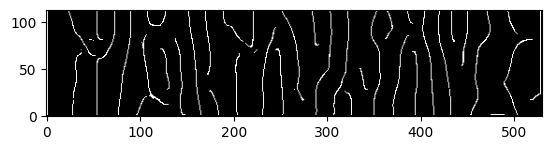

In [12]:
from skimage.feature import canny
from skimage.filters import sobel_v, sobel_h, threshold_otsu, threshold_local, median
from skimage.morphology import closing, opening, footprint_rectangle, disk
import numpy as np

images = PdB_ft.detach().clone().numpy()
for image in images:
    mask  = image > threshold_otsu(image)

    indices = np.where(mask.mean(1) < 0.7)[0].tolist()
    image   = image[:indices[0],:]

    indices = np.where((image == images.min()).all(0))[0].tolist()
    if indices:
        image = image[:,:indices[0]]

    image = canny(sobel_v(image), 10)
    
    plt.imshow(image, 'gray', origin='lower')
    plt.show()

In [13]:
raise Exception('Stop here')

Exception: Stop here

In [ ]:
import torch.nn.functional as F

kernel = 20
stride = 5

f_bins, t_bins = PdB_ft.shape[1:]
segments = F.unfold(
    PdB_ft.unsqueeze(1),
    kernel_size = (f_bins, kernel),
    stride = (f_bins, stride)
).transpose(2,1).reshape(2, -1, f_bins, kernel)
seg_A, seg_B = segments.flatten(2)
cross_corr   = (seg_A @ seg_B.T) / seg_A.shape[-1] ** 2
plt.imshow(cross_corr, origin='lower')

In [ ]:
import pandas as pd
from itertools import combinations

def generate_record(stride:int, complement_value:bool):
    ratio = 1 / stride
    if not complement_value:
        ratio = 1 - ratio
    approx_ratio = round(ratio, 2)
    return {
        'stride': stride,
        'complement_value': complement_value,
        'ratio': ratio,
        'approx_ratio': approx_ratio,
        'deviation': abs(ratio - approx_ratio),
    }

def prepare_subsampling_map():

    records = []
    for stride in range(2, 101):
        records.append(generate_record(stride, True))
        records.append(generate_record(stride, False))
        
    df = pd.DataFrame.from_records(records)
    df = df.sort_values('deviation').groupby(['approx_ratio', 'complement_value']).head(1)
    df = df.drop_duplicates('approx_ratio').sort_values('approx_ratio').reset_index(drop=True)
    df.drop(['approx_ratio', 'deviation'], axis=1, inplace=True)
    
    records = df.to_dict(orient='records')
    pair_records = [
        [x for record in record_pair for x in record.values()] \
        for record_pair in combinations(records, 2)
    ]
    records = [list(record.values()) + [1, True, 1.0] for record in records]
    pair_records = records + pair_records
    
    columns = [f'{col}_{x}' for x in 'ab' for col in df.columns]
    df = pd.DataFrame(pair_records, columns=columns)
    
    df['ratio'] = df['ratio_a'] * df['ratio_b']
    
    df['approx_ratio'] = df['ratio'].round(2)
    df['deviation'] = abs(df['ratio'] - df['approx_ratio'])
    df = df.sort_values('deviation').groupby('approx_ratio').head(1)
    df = df.drop_duplicates('approx_ratio').sort_values('approx_ratio')
    df.drop(['ratio', 'deviation'], axis=1, inplace=True)
    mask = (df['approx_ratio'] < 0.005) | (df['approx_ratio'] > 0.995)
    df = df[~mask].reset_index(drop=True)
    
    df['scale_factor_a'] = df['approx_ratio'].copy()
    gt_mask_a = df['ratio_a'] > df['ratio_b']
    df.loc[gt_mask_a, 'scale_factor_a'] = round(1 / df.loc[gt_mask_a, 'approx_ratio'], 2)
    
    df['scale_factor_b'] = df['approx_ratio'].copy()
    gt_mask_b = df['ratio_b'] > df['ratio_a']
    df.loc[gt_mask_b, 'scale_factor_b'] = round(1 / df.loc[gt_mask_b, 'approx_ratio'], 2)
    
    df.drop(['ratio_a', 'ratio_b', 'approx_ratio'], axis=1, inplace=True)
    
    assert all(df['scale_factor_a'] < df['scale_factor_b']), 'Scale A should be normalized to always result in shrinking A [0.01 to 0.99] (i.e. Stretching B)'
    
    df.drop('scale_factor_b', axis=1, inplace=True)
    df.set_index('scale_factor_a', inplace=True)
    
    return df

subsampling_map = prepare_subsampling_map()
subsampling_map

In [ ]:
def make_subsampling_mask(f_bins, t_bins, complement_value, stride):
    blank_tensor = torch.zeros if complement_value else torch.ones
    mask = blank_tensor(f_bins, t_bins, dtype=bool)
    mask[:, ::stride] = bool(complement_value)
    return mask

def scale_a(PdB_ft, stride_a, complement_value_a, stride_b, complement_value_b):
    
    masks = torch.stack([
        make_subsampling_mask(f_bins, t_bins, complement_value_a, stride_a), 
        make_subsampling_mask(f_bins, t_bins, complement_value_b, stride_b),
    ])
    
    t_lengths = masks[:,0,:].sum(-1)
    t_pads    = torch.max(t_lengths) - t_lengths
    
    scaled_PdB_ft = torch.stack([
        F.pad(
            PdB_ft[idx, masks[idx]].reshape([f_bins, t_lengths[idx]]),
            pad   = (0, t_pads[idx]),
            value = PdB_ft[idx].min()
        ) for idx in range(2)
    ])

    return scaled_PdB_ft

scaled_PdB_ft = scale_a(PdB_ft, *subsampling_map.loc[0.20])
scaled_PdB_ft.shape

In [ ]:
raise Exception('Stop here')

In [ ]:
import torch.nn.functional as F

F.unfold(PdB_ft.flatten(1), kernel_size=40, stride=10).shape

In [ ]:
import torch.nn.functional as F

time_bins = PdB_ft.shape[-1]
frame_bins = 40

PdB_ft = F.pad(PdB_ft, pad=(0, frame_bins - time_bins % frame_bins), value=PdB_ft.min())
PdB_ft.shape

In [ ]:
segments = torch.split(PdB_ft.unsqueeze(1), frame_bins, -1)
segments_A, segments_B = torch.concat(segments, 1).flatten(2)
segments_A.shape, segments_B.shape

In [ ]:
vector_bins = segments_A.shape[-1]
similarity  = (segments_A @ segments_B.T) / vector_bins ** 2
plt.imshow(similarity, origin='lower', cmap='viridis')

In [ ]:
h, w = similarity.shape


In [ ]:
raise Exception()

In [ ]:
import torch
import torch.nn.functional as F

pad = lambda samples: F.pad(samples, pad=(0, MAX_SAMPLES - len(samples)), value=samples.abs().min())
X_t = torch.stack([pad(dataset[idx]) for idx in (i, j)])
original_samples = max(dataset[idx].numel() for idx in (i, j))
X_t.shape

In [ ]:
X_ft = Spectrogram(X_t)
A_ft, phi_ft = map(lambda func: func(X_ft), [torch.abs, torch.angle])
X_ft = A_ft * torch.exp(1j * phi_ft)
X_t  = InvSpectrogram(X_ft)
display(Audio(X_t[0], rate=SAMPLERATE))
display(Audio(X_t[1], rate=SAMPLERATE))

In [ ]:
import matplotlib.pyplot as plt

PdB_ft = 10 * torch.log10(A_ft + 1e-6)
PdB_ft = PdB_ft.detach().clone().numpy()
_, axs = plt.subplots(2, 1, figsize=(10, 4))
axs[0].imshow(PdB_ft[0], origin='lower')
axs[1].imshow(PdB_ft[1], origin='lower')

In [ ]:
import numpy as np

mask = PdB_ft > PdB_ft.min((1,2)).reshape(-1,1,1)
mask[:,-1,:].sum(-1)

In [ ]:
frame = 
hop   
= HOP_MS * SAMPLERATE // 1000


In [ ]:
raise Exception('Stop here!')

In [ ]:
PdB_ft = 10 * torch.log10(A_ft + 1e-6)
images = PdB_ft.detach().clone().numpy()
_, axs = plt.subplots(2, 1, figsize=(10, 4))
axs[0].imshow(images[0], origin='lower')
axs[1].imshow(images[1], origin='lower')

In [ ]:
bin_images = images > 1
for idx in range(2):
    bin_images[idx] = closing(bin_images[idx], footprint=footprint_rectangle([5,5]))
    bin_images[idx] = opening(bin_images[idx], footprint=footprint_rectangle([5,5]))
    plt.imshow(bin_images[idx, :150, :750], origin='lower', cmap='gray')
    plt.show()

In [ ]:
import numpy as np

idx_mask = np.where(bin_images[:, 0])


In [ ]:
masks = bin_images[:, 0]
masks